# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 2-1
### Authors

- B073040018 朱劭璿
- B072010029 陳居廷

#### Regarding 50 2D-vectors $(u1, u2)$ in `HW2-1.csv`. Please use *Tensorflow 2.0* to design multi-layer neural networks to generate the data distribution similar to these vectors. Then plot the real data and the genrated data on a 2D-plane with different colors.

> Hint: The candidate model architectures include autoencoders, generative adversaroal networks, etc.

In [1]:
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt
BATCH_SIZE = 50

## Import data

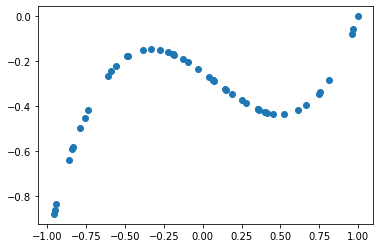

In [2]:
DATA_DIR = '../data/'
u1_raw = []
u2_raw = []
with open(DATA_DIR+'HW2-1.csv', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        u1_raw.append(float(row['U1']))
        u2_raw.append(float(row['U2']))
        
plt.scatter(u1_raw, u2_raw)

u1 = np.array(u1_raw).reshape(-1, 1)
u2 = np.array(u2_raw).reshape(-1, 1)
dataset = np.concatenate((u1, u2), axis=-1).astype(np.float32)
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(50).batch(BATCH_SIZE)

## Notion
The data distribution follows a polynomial curve. Let's say we have a random normal distribution with $\mu = (0, -0.5)$ and $\sigma = (1, 0.5)$

We want a function that transform $z$ into the 2D target distribution. We can approach this with neural networks and train them with an adversarial loss, which implies a discriminative neural network checking if the transformed distrubtion is similar to the target one.

## Define Model Architecture

In [3]:
class DenseBlock(tf.keras.Model):
    def __init__(
        self,
        out_nodes,
        norm_layer = tf.keras.layers.BatchNormalization,
        dropout: float = 0.
    ):
        super(DenseBlock, self).__init__()
        layers = [tf.keras.layers.Dense(out_nodes, activation='tanh')]
        if norm_layer:
            layers.append(norm_layer())
        if dropout:
            layers.append(tf.keras.layers.Dropout(dropout))
            
        self.model = tf.keras.models.Sequential([*layers])
        
    def call(self, x):
        return self.model(x)
    
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__(name='Generator')
        layers = []
        for _ in range(4):
            layers.append(DenseBlock(512))
            
        layers.append(tf.keras.layers.Dense(2))
        self.model = tf.keras.models.Sequential([*layers])
        
    def call(self, x, training=None):
        return self.model(x, training=training)

class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__(name='Discriminator')
        layers = []
        for _ in range(4):
            layers.append(DenseBlock(512))
            
        layers.append(tf.keras.layers.Dense(1))
        self.model = tf.keras.models.Sequential([*layers])
        
    def call(self, x, training=None):
        return self.model(x, training=training)
    
G = Generator()
D = Discriminator()

G.build(input_shape=(None, 2))
D.build(input_shape=(None, 2))
print(G.summary())
print(D.summary())

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 2)                 798722    
Total params: 798,722
Trainable params: 794,626
Non-trainable params: 4,096
_________________________________________________________________
None
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 1)                 798209    
Total params: 798,209
Trainable params: 794,113
Non-trainable params: 4,096
_________________________________________________________________
None


## Define the Loss and Optimizers

In [4]:
def discriminator_loss(real_logit, fake_logit):
    real_loss = -tf.reduce_mean(real_logit)
    fake_loss = tf.reduce_mean(fake_logit)
    return real_loss + fake_loss
def generator_loss(fake_logit):
    return -tf.reduce_mean(fake_logit)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-6,
    decay_steps=100000,
    decay_rate=0.94
)

D_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5, beta_2=0.9)
G_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5, beta_2=0.9)

## Define Training Loop

In [5]:
EPOCHS = 2001
D_REPEAT = 1
GP_WEIGHT = 10

![wgangp](./images/wgangp.png)

> Image credit to Prof. HUNG-YI LEE

In [6]:
def train_step(data):
    D_loss = None; G_loss = None
    for _ in range(D_REPEAT):
        D_loss = train_D(data)
    
    G_loss = train_G(data)
    
    return D_loss, G_loss

# This decorator implies we're using the Graph
# So it can run in Tensorflow backend instead of Python
# A lot Faster!!
@tf.function
def train_D(data):
    def gradient_penalty(real_data, gen_data):
        interpolation_samples = tf.random.uniform([real_data.shape[0], 2], real_data, gen_data)
        with tf.GradientTape() as tape:
            tape.watch(interpolation_samples)
            out = D(interpolation_samples, training=True)
        grads = tape.gradient(out, [interpolation_samples])
        # The epsilon(small number) 1e-12 is require to prevent inf norm in Tensorflow.
        # For example, when x = 0, d(norm(x))/dx would go infinity
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=-1) + 1e-12)
        return tf.reduce_mean((norm - 1)**2)
    
    noise = tf.random.normal((data.shape[0], 2), (0, -.5), (1, .5))
    with tf.GradientTape() as D_tape:
        G_data = G(noise, training=False)
        real_output = D(data, training=True)
        fake_output = D(G_data, training=True)
        
        D_loss = discriminator_loss(real_output, fake_output)
        D_loss += GP_WEIGHT*gradient_penalty(data, G_data)
    
    D_grads = D_tape.gradient(D_loss, D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grads, D.trainable_variables))
    return D_loss

@tf.function
def train_G(data):
    noise = tf.random.normal((data.shape[0], 2), (0, -.5), (1, .5))
    with tf.GradientTape() as G_tape:
        G_data = G(noise, training=True)
        fake_output = D(G_data, training=False)

        G_loss = generator_loss(fake_output)
        
    G_grads = G_tape.gradient(G_loss, G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grads, G.trainable_variables))
    return G_loss

In [7]:
from tqdm import tqdm
from IPython.display import clear_output
import imageio
import os

fix_samples = tf.random.normal((1000, 2), (0, -.5), (1, .5))

def train(dataset, epochs):
    buf_dir = 'out-images'
    os.system(f'rm -rf {buf_dir}')
    os.system(f'mkdir {buf_dir}')
    for epoch in range(epochs):
        D_loss = None; G_loss = None
        for batch in dataset:
            D_loss, G_loss = train_step(batch)
            
        if epoch % 20 == 0:
            clear_output()
            print(f'Epoch: {epoch}')
            print(f'Discrminator: {D_loss: .4f}, Generator: {G_loss: .4f}')
            out = G(fix_samples, training=False)
            out = ROI(out)
            plt.clf()
            plt.scatter(u1_raw, u2_raw)
            plt.scatter(out[:, 0], out[:, 1])
            if epoch % 40 == 0:
                plt.savefig(f'{buf_dir}/{epoch}.jpg')
            plt.show()
            
    gif_path = 'out.gif'
    os.system(f'rm {gif_path}')
    with imageio.get_writer(gif_path, mode='I') as writer:
        for epoch in range(0, epochs, 40):
            writer.append_data(imageio.imread(f'{buf_dir}/{epoch}.jpg'))
            
    os.system(f'rm -rf {buf_dir}')
    
def ROI(out):
    def get_mask(out, index, op, threshold):
        if op == 'l':
            return out[:, index] < threshold
        return out[:, index] > threshold
    for i, op, thres in zip(
        [0, 0, 1, 1],
        'lglg',
        [1, -1, 0, -1]
    ):
        mask = get_mask(out, i, op, thres)
        out = out[mask]
    return out

Epoch: 2000
Discrminator:  10.0000, Generator: -0.2817


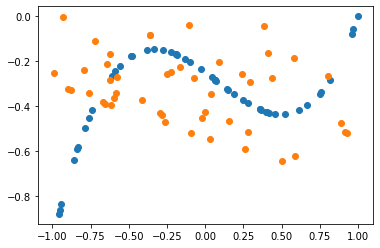

In [8]:
train(dataset, EPOCHS)


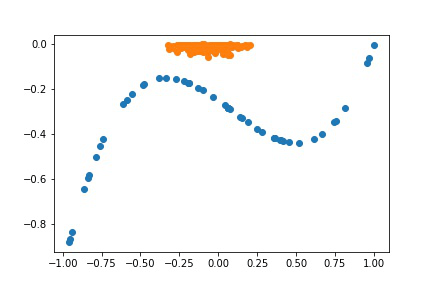

In [9]:
import tensorflow_docs.vis.embed as embed
embed.embed_file('out.gif')